In [2]:
import pyodbc
import pandas as pd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

try:
    conn_str = "Driver={SQL Server};Server=Z690-ELDER;Database=SentimentAnalysis;Trusted_Connection=yes;"
    conn_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_str})
    engine = create_engine(conn_url)
        
    df = pd.read_sql("SELECT * FROM dbo.Twitter", engine)
            
except pyodbc.Error as e:
    print("Error while connecting to db", e)

#display UserKey and Tweet
df[['UserKey', 'Tweet']].style

test = df[['UserKey', 'Tweet']]
test.columns = ['id', 'text']

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords

train_original = pd.read_csv('./TrainingData/trainingdata2.csv')
train_original.columns = ['target','id','date','flag','user','text']

train=train_original[['id','text', 'target']]

In [3]:
combine = train.append(test,ignore_index=True,sort=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_21528\2428539335.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combine = train.append(test,ignore_index=True,sort=True)


In [12]:
from nltk import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
import re
sw = stopwords.words('english')

#remove useful words from the stopword list
sw.remove('not')
sw.remove('no')
sw.remove('nor')
sw.remove("won't")
sw.remove("wouldn't")
sw.remove("shouldn't")
sw.remove("couldn't")
sw.remove('against')
sw.remove("aren't")
sw.remove("haven't")
sw.remove("hasn't")
sw.remove("doesn't")
sw.remove("isn't")

def remove_pattern(text,pattern):
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

def stem_sentences(sentence):
    #tokenize the sentence and remove the stems of the words
    ps = PorterStemmer()
    tokens = sentence.split()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def preprocessTweet(df, sw):
    #remove newlines
    df['modText'] = df['text'].str.replace("\n"," ")
    #turn all text to lowercase
    df['modText'] = df['modText'].str.lower()
    # remove twitter handles (@user)
    df['modText'] = np.vectorize(remove_pattern)(df['modText'], "@[\w]*")
    #remove links
    df['modText'] = df['modText'].str.replace('http\S+|www.\S+', '', case=False)
    #remove special characters, numbers, punctuations
    df['modText'] = df['modText'].str.replace("[^a-zA-Z#]", " ")
    #remove short words (length < 3)
    df['modText'] = df['modText'].apply(lambda x: ' '.join([w for w in x.split() if (len(w)>3 or w == 'no')]))
    #remove duplicate tweets - bot prevention
    df['modText'] = df['modText'].drop_duplicates(keep=False)
    #remove quotes
    df['modText'] = df['modText'].str.replace("quot", "")
    #remove NANs
    df.dropna(inplace=True)
    #remove stopwords
    df['modText'] = df['modText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))
    #remove empty tweets
    df = df[df.modText != '']
    #stemming
    df['modText'] = df['modText'].apply(stem_sentences)
    return df

test = preprocessTweet(test, stopwords.words('english'))

C:\Users\andre\AppData\Local\Temp\ipykernel_9772\3762757388.py:47: FutureWarning: The default value of regex will change from True to False in a future version.
  df['modText'] = df['modText'].str.replace('http\S+|www.\S+', '', case=False)
C:\Users\andre\AppData\Local\Temp\ipykernel_9772\3762757388.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  df['modText'] = df['modText'].str.replace("[^a-zA-Z#]", " ")
C:\Users\andre\AppData\Local\Temp\ipykernel_9772\3762757388.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['modText'] = df['modText'].apply(stem_sentences)


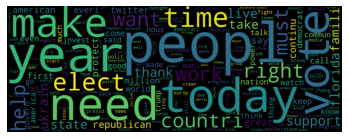

In [13]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt

all_words = ' '.join(text for text in test['modText'])

#mage_colors = ImageColorGenerator(img) #can use image to color the wordcloud

wc = WordCloud(background_color='black', height=1500, width=4000).generate(all_words)
plt.axis('off')
plt.imshow(wc,interpolation="hamming")

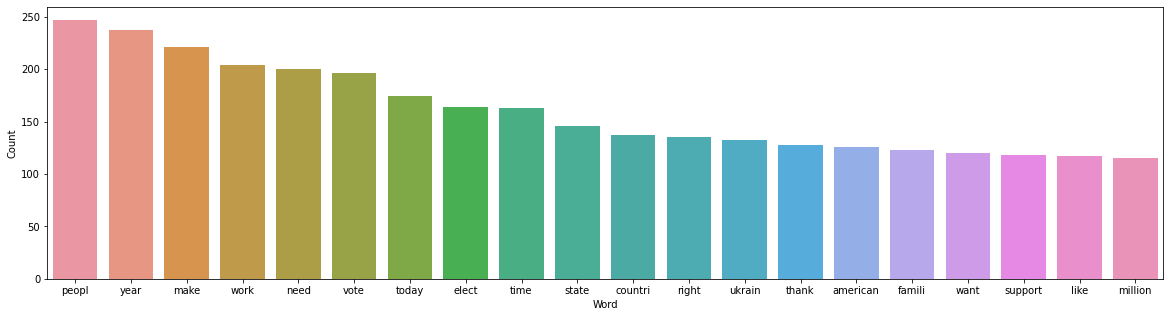

In [17]:
import nltk
import seaborn as sns

#display the most common words
all_words = ' '.join(text for text in test['modText'])
all_words = all_words.split()
freq_dist = nltk.FreqDist(all_words)
df = pd.DataFrame({'Word':list(freq_dist.keys()), 'Count':list(freq_dist.values())})
d = df.nlargest(columns="Count", n = 20)
plt.figure(figsize=(20,5))

ax = sns.barplot(data=d, x= "Word", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combine['Tidy_Tweets'])

df_bow = pd.DataFrame(bow.todense())

df_bow

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1418909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1418910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1418911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Term Frequency-Inverse Document Frequency (TF-IDF)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(combine['Tidy_Tweets'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1418909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.443328,0.0,0.0,0.0
1418910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1418911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [9]:
train_bow = bow[:1418913]

train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
train_tfidf_matrix = tfidf_matrix[:1418913]

train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
#split the data into train and test

from sklearn.model_selection import train_test_split

#bag of words features
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,combine['target'],test_size=0.3,random_state=2)

#tfidf features
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,combine['target'],test_size=0.3,random_state=17)

In [12]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy', random_state=1)

dct.fit(x_train_bow,y_train_bow)

dct_bow = dct.predict_proba(x_valid_bow)

dct_bow

ValueError: Input y contains NaN.

In [ ]:
from sklearn.metrics import f1_score
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_bow=dct_bow[:,1]>=0.3

# converting the results to integer type
dct_int_bow=dct_bow.astype(np.int)

# calculating f1 score
dct_score_bow=f1_score(y_valid_bow,dct_int_bow)

dct_score_bow

In [ ]:
dct.fit(x_train_tfidf,y_train_tfidf)

dct_tfidf = dct.predict_proba(x_valid_tfidf)
dct_tfidf

In [ ]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf)

dct_score_tfidf

In [2]:
import pyodbc
import pandas as pd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras import backend
import tensorflow as tf
from nltk import word_tokenize
from gensim import models

train_original = pd.read_csv('./TrainingData/trainingdata2.csv')
train_original.columns = ['target','id','date','flag','user','text']

df=train_original[['id','text', 'target']]

del train_original

#region prepare stopwords list
sw = stopwords.words('english')

#remove useful words from the stopword list
sw.remove('not')
sw.remove('no')
sw.remove('nor')
sw.remove("won't")
sw.remove("wouldn't")
sw.remove("shouldn't")
sw.remove("couldn't")
sw.remove('against')
sw.remove("aren't")
sw.remove("haven't")
sw.remove("hasn't")
sw.remove("doesn't")
sw.remove("isn't")
#endregion

def remove_pattern(text,pattern):
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

def preprocessTweet(df):
    #remove newlines
    df['text'] = df['text'].str.replace("\n"," ")
    #turn all text to lowercase
    df['text'] = df['text'].str.lower()
    # remove twitter handles (@user)
    df['text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")
    #remove links
    df['text'] = df['text'].str.replace('http\S+|www.\S+', '', case=False)
    #remove special characters, numbers, punctuations
    df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")
    #remove quotes
    df['text'] = df['text'].str.replace("quot", "")
    #remove stopwords
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))
    #remove short words (length < 2)
    df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if (len(w)>2)]))
    #remove duplicate tweets - bot prevention
    df['text'] = df['text'].drop_duplicates(keep=False)
    #remove NANs
    df.dropna(inplace=True)
    #remove empty tweets
    df = df[df.text != '']
    return df

df = preprocessTweet(df)

C:\Users\andre\AppData\Local\Temp\ipykernel_17196\1653399395.py:68: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('http\S+|www.\S+', '', case=False)
C:\Users\andre\AppData\Local\Temp\ipykernel_17196\1653399395.py:70: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")


In [30]:
import nltk
#tokenize first 1000 tweets
a = "wtf is going on"
tokens1000 = [word_tokenize(i) for i in a]